In [76]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

In [77]:
local_ip = "10.215.173.1"
dl_pkts = np.zeros([0, 3])
ul_pkts = np.zeros([0, 3])

for i in [2]:
  filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_{}.csv".format(i)

  df = load_csv(filename)
  # stats_src_ip(df)
  # stats_dst_ip(df)
  dl_data = extract_dl_pkt_interval_time(df, local_ip)
  ul_data = extract_ul_pkt_interval_time(df, local_ip)
  dl_pkts = np.concatenate((dl_pkts, dl_data), axis=0)
  ul_pkts = np.concatenate((ul_pkts, ul_data), axis=0)
  print(dl_pkts.shape)
  print(ul_pkts.shape)
  # dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
  # ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

(4092384, 3)
(562975, 3)


In [78]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=1000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=1000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

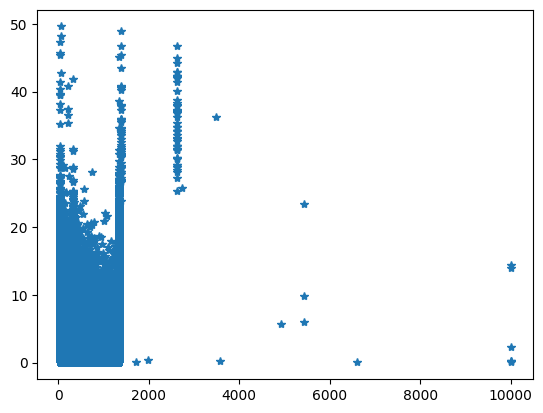

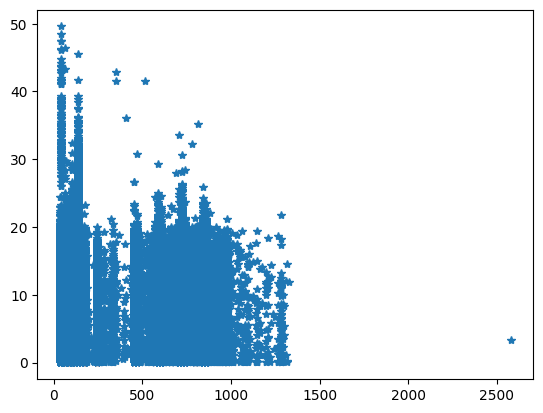

In [79]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

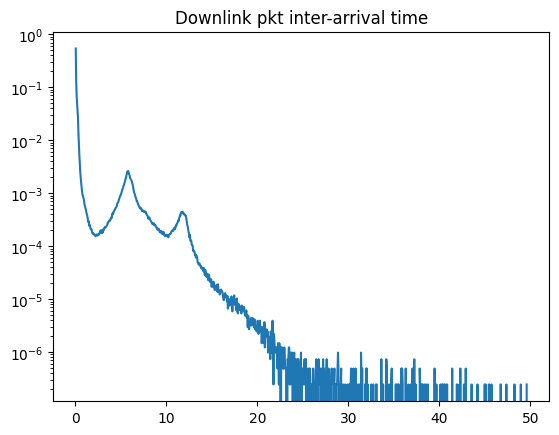

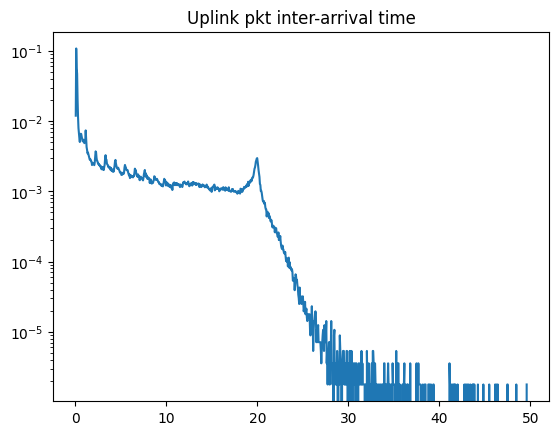

In [80]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [81]:
train = torch.tensor(ul_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

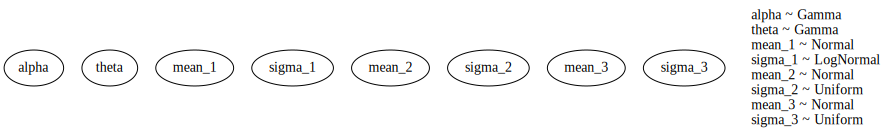

In [82]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    mean_3 = pyro.sample("mean_3", dist.Normal(20, 2))
    sigma_3 = pyro.sample("sigma_3", dist.Uniform(0., 0.05))
    gaussian_3 = dist.Normal(mean_3, sigma_3)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    gaussian_samp_3 = gaussian_3.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [83]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    mean_3_loc = pyro.param('mean_3_loc', lambda: torch.tensor(12. ))
    sigma_3_loc = pyro.param('sigma_3_loc', lambda: torch.tensor(0.))
    mean_3 = pyro.sample('mean_3', dist.Normal(mean_3_loc, torch.tensor(0.05)))
    sigma_3 = pyro.sample('sigma_3', dist.LogNormal(sigma_3_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2, 'mean_3': mean_3, 'sigma_3': sigma_3}

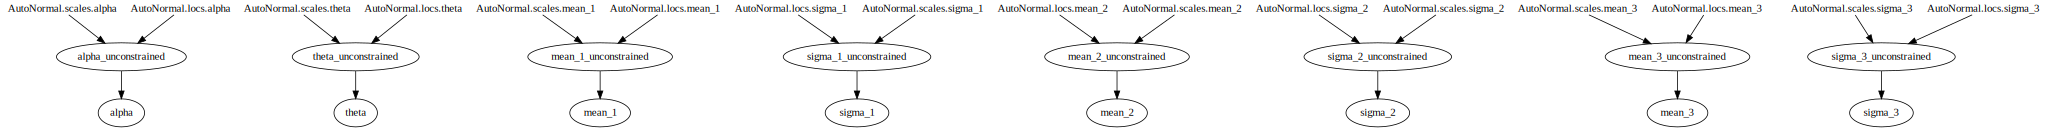

In [84]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [85]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Step: 0, Elbo loss: -2.1606340780854225
Step: 100, Elbo loss: 0.24192598275840282
Step: 200, Elbo loss: 0.16247446835041046
Step: 300, Elbo loss: 0.027327891439199448
Step: 400, Elbo loss: 0.2818102966994047
Step: 500, Elbo loss: -0.8979630023241043
Step: 600, Elbo loss: 0.4227606747299433
Step: 700, Elbo loss: 0.0071137696504592896
Step: 800, Elbo loss: 0.10911945626139641
Step: 900, Elbo loss: 0.07358879968523979
Step: 1000, Elbo loss: -0.31251318380236626
Step: 1100, Elbo loss: -0.0930747427046299
Step: 1200, Elbo loss: 0.3007345497608185
Step: 1300, Elbo loss: -0.6562825329601765
Step: 1400, Elbo loss: 0.664950467646122
Step: 1500, Elbo loss: -0.12489337474107742
Step: 1600, Elbo loss: 0.6948913745582104
Step: 1700, Elbo loss: -1.5980716198682785
Step: 1800, Elbo loss: 0.9238100275397301
Step: 1900, Elbo loss: 0.4802626259624958
Step: 2000, Elbo loss: 0.6222710162401199
Step: 2100, Elbo loss: 0.8422350771725178
Step: 2200, Elbo loss: 1.1320400200784206
Step: 2300, Elbo loss: 0.0977

Text(0, 0.5, 'ELBO loss')

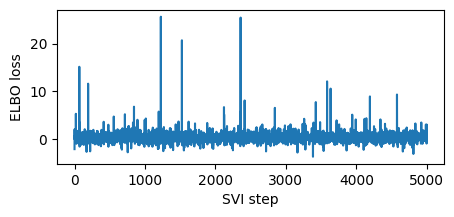

In [86]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

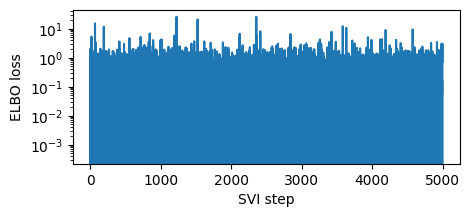

In [87]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [88]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.3942031
AutoNormal.scales.alpha 1.0421245
AutoNormal.locs.theta -0.30771464
AutoNormal.scales.theta 1.0556047
AutoNormal.locs.mean_1 5.043033
AutoNormal.scales.mean_1 1.8304849
AutoNormal.locs.sigma_1 0.034294523
AutoNormal.scales.sigma_1 0.052054353
AutoNormal.locs.mean_2 11.8782015
AutoNormal.scales.mean_2 2.0299997
AutoNormal.locs.sigma_2 0.43530318
AutoNormal.scales.sigma_2 1.8384833
AutoNormal.locs.mean_3 19.73777
AutoNormal.scales.mean_3 2.1036928
AutoNormal.locs.sigma_3 0.041061994
AutoNormal.scales.sigma_3 1.6548132


In [ ]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  gaussian_samp_3 = dist.Normal(svi_samples['mean_3'][0], svi_samples['sigma_3'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.6, 0.1, 0.1, 0.2]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2 + y[3] * gaussian_samp_3)
  
print(res)

[tensor(16.5528), tensor(1.1582), tensor(0.8746), tensor(0.9078), tensor(14.8415), tensor(15.8945), tensor(14.9344), tensor(23.7727), tensor(0.0210), tensor(11.5074), tensor(15.2340), tensor(9.9362), tensor(12.2391), tensor(0.1090), tensor(3.4109), tensor(6.9347), tensor(0.5990), tensor(1.2743), tensor(0.2937), tensor(1.0933), tensor(19.6522), tensor(5.3339), tensor(17.2864), tensor(0.4625), tensor(2.2435), tensor(4.3747), tensor(19.0669), tensor(1.3141), tensor(1.8456), tensor(0.5596), tensor(1.2841), tensor(19.3139), tensor(0.4832), tensor(12.5759), tensor(0.7432), tensor(1.7594), tensor(0.6700), tensor(0.4140), tensor(13.7456), tensor(0.2826), tensor(0.8825), tensor(1.4897), tensor(1.3350), tensor(21.7869), tensor(4.1014), tensor(18.4909), tensor(22.1033), tensor(0.5518), tensor(14.0903), tensor(0.4889), tensor(18.2628), tensor(0.0348), tensor(3.9818), tensor(0.8575), tensor(4.5822), tensor(0.7876), tensor(1.0868), tensor(0.5165), tensor(1.2212), tensor(1.4108), tensor(1.6406), tens

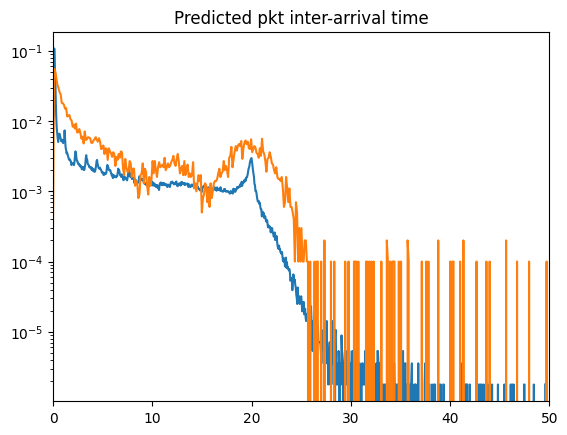

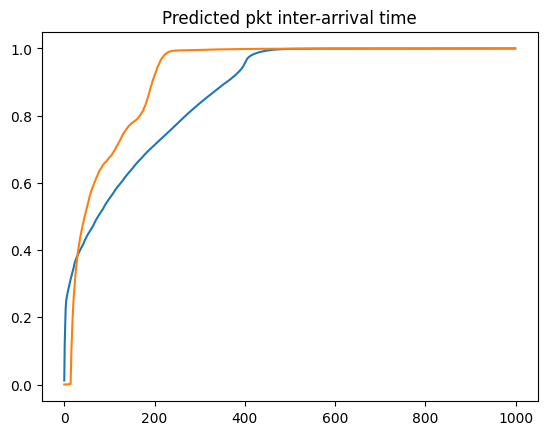

In [91]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
# plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf)
plt.xlim([0, 50])
# plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.figure()
plt.plot(ul_cdf)
# plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_cdf)
# plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.show()